# RQ1: Are ratings and number of reviews an indicator of business success?

## Part 3: How do ratings change over time? Is there a clear profile difference between open and closed businesses?

- For closed businesses, what is the lifespan of all the different star categories?
- How do ratings deviate? What's the difference between open and closed businesses?
- How do ratings deviate during the "last half" of a business' lifespan?
- Average rating during "first half" and average rating during "last half" of lifespan for open vs closed.

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../../data/..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%matplotlib inline

We will use two datasets, the reviews and the business info.

In [3]:
df = pd.read_csv("../../data/raw/yelp_review.csv") 
bus = pd.read_csv("../../data/raw/yelp_business.csv") 

Make a dataframe that details the first and last review of each business

In [4]:
#Filter the review dataset to just give the info we need and format dates correctly
rev = df.filter(['review_id', 'business_id', 'stars', 'date'])
rev['date'] =  pd.to_datetime(rev['date'], format='%Y-%m-%d')

#Assemble all the reviews of one business into a group.
groups = rev.groupby('business_id')
newRev = pd.DataFrame(groups.max()['date']) #get the latest date
newRev2 = pd.DataFrame(groups.min()['date']) #get the earliest date

#Make a datframe with the earliest and latest review of each business
dates = pd.concat([newRev, newRev2], axis=1)
dates.columns = ['lastReview', 'firstReview']

dates.head()

,lastReview,firstReview
business_id,,
--6MefnULPED_I942VcFNA,2017-12-04,2008-08-07
--7zmmkVg-IMGaXbuVd0SQ,2017-11-12,2014-12-30
--8LPVSo5i0Oo61X01sV9A,2017-06-28,2014-05-15
--9QQLMTbFzLJ_oT-ON3Xw,2017-05-02,2013-05-15
--9e1ONYQuAa-CB_Rrw7Tw,2017-12-11,2005-04-27


Calculate the lifespan of each business in days and convert this value from datetime to an int

In [8]:
dates['lifespan'] = dates.lastReview - dates.firstReview #lifespan if latest review in days, minus first review in days

def convert(a):
    b = a.total_seconds() #convert day to total seconds
    totSec = b/86400 #divide the seconds to give the amount of days
    totSec = int(totSec) #convert to int
    return totSec

dates['lifespan'] = dates.apply(lambda row: convert(row['lifespan']), axis=1) #convert all of the days to ints

Combine the business info and dates info we just made

In [9]:
biz = bus.filter(['business_id', 'name', 'stars', 'city', 'state', 'postal_code', 'review_count', 'is_open'])
biz = biz.set_index('business_id')
revInfo = pd.concat([biz, dates], axis=1)

revInfo.head()

,name,stars,city,state,postal_code,review_count,is_open,lastReview,firstReview,lifespan
--6MefnULPED_I942VcFNA,"""John's Chinese BBQ Restaurant""",3.0,Richmond Hill,ON,L4B 3P7,37,1,2017-12-04,2008-08-07,3406
--7zmmkVg-IMGaXbuVd0SQ,"""Primal Brewery""",4.0,Huntersville,NC,28078,47,1,2017-11-12,2014-12-30,1048
--8LPVSo5i0Oo61X01sV9A,"""Valley Bone and Joint Specialists""",4.5,Gilbert,AZ,85234,3,1,2017-06-28,2014-05-15,1140
--9QQLMTbFzLJ_oT-ON3Xw,"""Great Clips""",3.5,Tempe,AZ,85283,11,1,2017-05-02,2013-05-15,1448
--9e1ONYQuAa-CB_Rrw7Tw,"""Delmonico Steakhouse""",4.0,Las Vegas,NV,89109,1451,1,2017-12-11,2005-04-27,4611


How many days does this dataframe Span?

In [10]:
dfSpan = revInfo['lastReview'].max() - revInfo['firstReview'].min()
print(dfSpan)

4890 days 00:00:00


Why keep postcode? - Incase we want to do map studies on this topic.

## Lifespans of Closed Businesses by Star Category
Fix these because theres no labels

stars
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.5    AxesSubplot(0.125,0.125;0.775x0.755)
2.0    AxesSubplot(0.125,0.125;0.775x0.755)
2.5    AxesSubplot(0.125,0.125;0.775x0.755)
3.0    AxesSubplot(0.125,0.125;0.775x0.755)
3.5    AxesSubplot(0.125,0.125;0.775x0.755)
4.0    AxesSubplot(0.125,0.125;0.775x0.755)
4.5    AxesSubplot(0.125,0.125;0.775x0.755)
5.0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

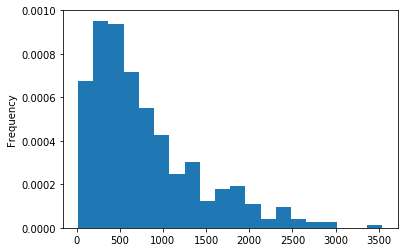

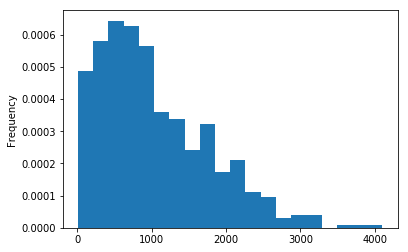

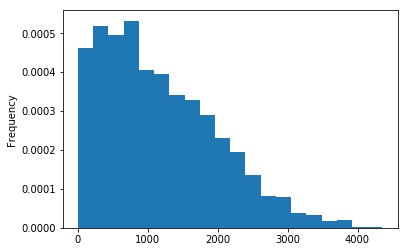

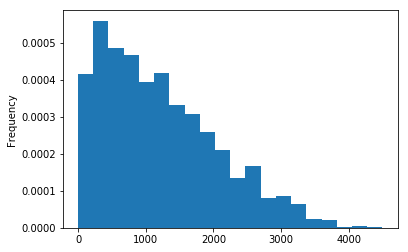

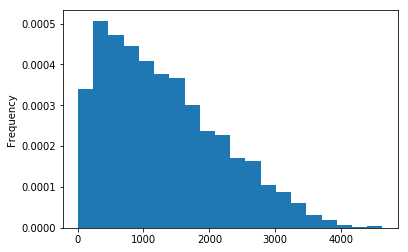

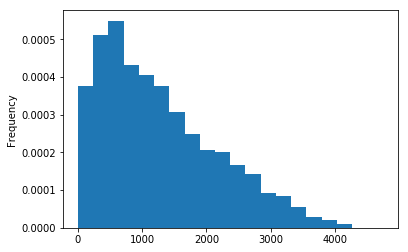

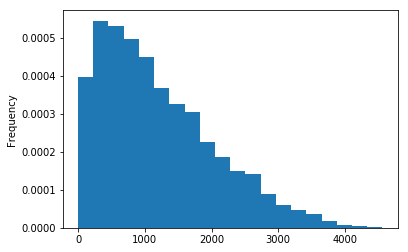

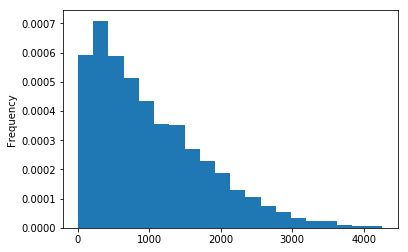

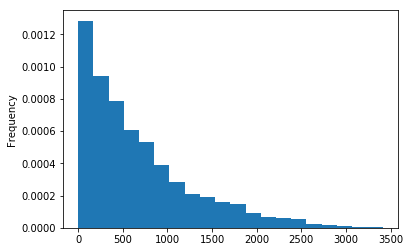

In [14]:
closed = revInfo[revInfo['is_open'] == 0] #0 denotes a closed business

closed.groupby('stars').plot(kind='hist', y ='lifespan', bins=20, legend=False, normed=1)

### Conclusions:
- Businesses that closed with 5 stars tend to have a shorter lifespan, the same as pattern as 1 star restaraunts.

## How do ratings deviate? What's the difference between open and closed businesses?

In [5]:
dateStudy = df.filter(['review_id', 'business_id', 'stars', 'date']) #only take thte columns we need
review_list = list(zip(dateStudy.date, dateStudy.stars)) #convert date and time of each review to a tuple
dateStudy['revrate'] = pd.Series(review_list) #make this a column in the dataset
dateStudy.head()

,review_id,business_id,stars,date,revrate
0,vkVSCC7xljjrAI4UGfnKEQ,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,"(2016-05-28, 5)"
1,n6QzIUObkYshz4dz2QRJTw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,"(2016-05-28, 5)"
2,MV3CcKScW05u5LVfF6ok0g,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,"(2016-05-28, 5)"
3,IXvOzsEMYtiJI0CARmj77Q,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,"(2016-05-28, 4)"
4,L_9BTb55X0GDtThi6GlZ6w,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,"(2016-05-28, 4)"


In [13]:
dateLists = dateStudy.groupby('business_id')['revrate'].apply(list)
reviewsTemplate = pd.DataFrame(dateLists)  # Make a dataframe of business id, all review info
reviewsTemplate.head()

,revrate
business_id,
--6MefnULPED_I942VcFNA,"[(2017-08-17, 4), (2017-05-31, 3), (2016-10-23..."
--7zmmkVg-IMGaXbuVd0SQ,"[(2015-11-30, 4), (2017-08-16, 4), (2016-08-18..."
--8LPVSo5i0Oo61X01sV9A,"[(2016-07-29, 3), (2017-06-28, 5), (2014-05-15..."
--9QQLMTbFzLJ_oT-ON3Xw,"[(2016-04-02, 2), (2013-05-15, 4), (2017-05-02..."
--9e1ONYQuAa-CB_Rrw7Tw,"[(2011-08-24, 5), (2016-03-31, 5), (2015-06-29..."


In [14]:
openClose = bus.filter(['business_id', 'is_open']) #get the "is_open" info from the original business dataframe
openClose = openClose.set_index('business_id') #set the index to business id

#Combine new review info and is_open info into a dataframe
reviews = pd.concat([reviewsTemplate, openClose], axis=1) 
reviews.head()

,revrate,is_open
--6MefnULPED_I942VcFNA,"[(2017-08-17, 4), (2017-05-31, 3), (2016-10-23...",1
--7zmmkVg-IMGaXbuVd0SQ,"[(2015-11-30, 4), (2017-08-16, 4), (2016-08-18...",1
--8LPVSo5i0Oo61X01sV9A,"[(2016-07-29, 3), (2017-06-28, 5), (2014-05-15...",1
--9QQLMTbFzLJ_oT-ON3Xw,"[(2016-04-02, 2), (2013-05-15, 4), (2017-05-02...",1
--9e1ONYQuAa-CB_Rrw7Tw,"[(2011-08-24, 5), (2016-03-31, 5), (2015-06-29...",1


### What does a rating timeline look for a business?
It's v messy I must clean :(

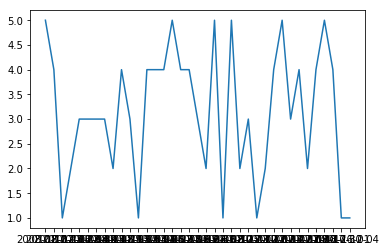

In [16]:
s = reviews['revrate'][0] #choose a business
sortS = sorted(s, key=lambda tup: tup[0]) #sort from earliest to latest
x,y = zip(*sortS) #sort tuples into x and y lists of values
plt.plot(x,y) #plot

In [17]:
closedBiz = reviews[reviews['is_open'] == 0] #make a closed business list
openBiz = reviews[reviews['is_open'] == 1] #make an open business list

#lists to hold the standard devations of each category
closedStds = []
openStds = []

#Get each closed business' review info, sort the ratings, calculate the devation for each business, add to list
for i in range(len(closedBiz)):
    s = closedBiz['revrate'][i]
    sortS = sorted(s, key=lambda tup: tup[0])
    x,y = zip(*sortS)
    standard = np.std(y)
    closedStds.append(standard)

#Get each open business' review info, sort the ratings, calculate the devation for each business, add to list
for i in range(len(openBiz)):
    s = openBiz['revrate'][i]
    sortS = sorted(s, key=lambda tup: tup[0])
    x,y = zip(*sortS)
    standard = np.std(y)
    openStds.append(standard)

### Standard Deviation of Open Vs. Closed:
Make a graph?

In [18]:
avg1 = float(sum(closedStds))/len(closedStds)
print("Average Standard Deviation of Closed Business' Reviews: " + str(avg1))

avg2 = float(sum(openStds))/len(openStds)
print("Average Standard Deviation of Open Business' Reviews: " + str(avg2))

Average Standard Deviation of Closed Business' Reviews: 1.0629774419594056
Average Standard Deviation of Open Business' Reviews: 1.0681105124597579


### What about in the "last half" of their lifespan?

In [26]:
closedBiz = reviews[reviews['is_open'] == 0]
openBiz = reviews[reviews['is_open'] == 1]

closedStds = []
openStds = []

lenCB = int(len(closedBiz))
lenOB = int(len(openBiz))

for i in range(lenCB):
    s = closedBiz['revrate'][i]
    sortS = sorted(s, key=lambda tup: tup[0])
    x,y = zip(*sortS)
    half = int(len(y)/2)
    standard = np.std(y[half:])
    closedStds.append(standard)

for i in range(lenOB):
    s = openBiz['revrate'][i]
    sortS = sorted(s, key=lambda tup: tup[0])
    x,y = zip(*sortS)
    half = int(len(y)/2)
    standard = np.std(y[half:])
    openStds.append(standard)

0.9605787134072086
0.9452227083914434


In [28]:
avg1 = float(sum(closedStds))/len(closedStds)
print("Standard Deviation of Closed Reviews in Last Half of Lifespan: " + str(avg1))

avg2 = float(sum(openStds))/len(openStds)
print("Standard Deviation of Open Reviews in Last Half of Lifespan: " + str(avg2))

Standard Deviation of Closed Reviews in Last Half of Lifespan: 0.9605787134072086
Standard Deviation of Open Reviews in Last Half of Lifespan: 0.9452227083914434


### RQ1 Part 2) Number of Reviews vs. Standard Deviation of Rating

In [34]:
stds = []

for i in range(len(reviews)):
    s = reviews['revrate'][i]
    sortS = sorted(s, key=lambda tup: tup[0])
    x,y = zip(*sortS)
    standard = np.std(y)
    stds.append(standard)
    
reviews['devs'] = pd.Series(stds, index=reviews.index)

In [39]:
rev_count = []
for i in range(len(reviews)):
    count = len(reviews['revrate'][i])
    rev_count.append(count)
    
reviews['rev_count'] = pd.Series(rev_count, index=reviews.index)

In [133]:
one = reviews[reviews['rev_count'] < 1000]
two = one[one['rev_count'] > 10]

intervalGroups = pd.cut(two['rev_count'], 10)
reviews['revCountRange'] = pd.Series(intervalGroups, index=reviews.index)

reviews.head()

,revrate,is_open,devs,rev_count,revCountRange
--6MefnULPED_I942VcFNA,"[(2017-08-17, 4), (2017-05-31, 3), (2016-10-23...",1,1.318520,37,"(10.013, 109.7]"
--7zmmkVg-IMGaXbuVd0SQ,"[(2015-11-30, 4), (2017-08-16, 4), (2016-08-18...",1,1.220023,47,"(10.013, 109.7]"
--8LPVSo5i0Oo61X01sV9A,"[(2016-07-29, 3), (2017-06-28, 5), (2014-05-15...",1,0.942809,3,NaN
--9QQLMTbFzLJ_oT-ON3Xw,"[(2016-04-02, 2), (2013-05-15, 4), (2017-05-02...",1,1.720081,11,"(10.013, 109.7]"
--9e1ONYQuAa-CB_Rrw7Tw,"[(2011-08-24, 5), (2016-03-31, 5), (2015-06-29...",1,1.109303,1451,NaN


The more reviews a business have, the more consistently they are reviews (in that same group of review number)

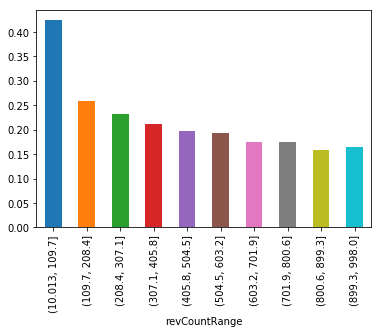

In [131]:
groups = reviews.groupby('revCountRange')
groups['devs'].std().plot(kind='bar')


### Average rating during "first half" and average rating during "last half" of lifespan for open vs closed.

In [162]:
closedBiz = reviews[reviews['is_open'] == 0]
openBiz = reviews[reviews['is_open'] == 1]

closedMeanFirst = []
openMeanFirst = []
closedMeanSecond = []
openMeanSecond = []

lenCB = int(len(closedBiz))
lenOB = int(len(openBiz))

for i in range(lenCB):
    s = closedBiz['revrate'][i]
    sortS = sorted(s, key=lambda tup: tup[0])
    x,y = zip(*sortS)
    
    if len(y) > 4:
        quarter = (len(y)/4)
        q3 = int(quarter*3)
        firstRating = (y[:q3])
        sum1 = 0
        for i in firstRating:
            sum1 = sum1 + i
    
        fR = sum1/len(firstRating)
        
        secondRating = (y[q3:])
    
        sum2 = 0
        for i in secondRating:
            sum2 = sum2 + i
        
        sR = sum2/len(secondRating)
        
        closedMeanFirst.append(fR)
        closedMeanSecond.append(sR)
    else:
        closedMeanSecond.append(y[0])


for i in range(lenOB):
    s = openBiz['revrate'][i]
    sortS = sorted(s, key=lambda tup: tup[0])
    x,y = zip(*sortS)
    
    if len(y) > 4:
        quarter = (len(y)/4)
        q3 = int(quarter*3)
        
        firstRating = (y[:q3])
        sum1 = 0
        for i in firstRating:
            sum1 = sum1 + i
    
        fR = sum1/len(firstRating)
        
        secondRating = (y[q3:])
    
        sum2 = 0
        for i in secondRating:
            sum2 = sum2 + i
        
        sR = sum2/len(secondRating)
        openMeanFirst.append(fR)
        openMeanSecond.append(sR)
    else:
        openMeanSecond.append(y[0])
    
cFmean = float(sum(closedMeanFirst))/len(closedMeanFirst)
print("Average Rating for Closed Businesses in First Half of Lifespan: " + str(cFmean))

oFmean = float(sum(openMeanFirst))/len(openMeanFirst)
print("Average Rating for Open Businesses in First Half of Lifespan: " + str(oFmean))

cSmean = float(sum(closedMeanSecond))/len(closedMeanSecond)
print("Average Rating for Closed Businesses in Second Half of Lifespan: " + str(cSmean))

oSmean = float(sum(openMeanSecond))/len(openMeanSecond)
print("Average Rating for Open Businesses in Second Half of Lifespan: " + str(oSmean))

print("Conclusions:")
print("Closed Rating drop by " + str(cFmean-cSmean))
print("Open Rating drop by " + str(oFmean-oSmean))


Average Rating for Closed Businesses in First Half of Lifespan: 3.5853801102356906
Average Rating for Open Businesses in First Half of Lifespan: 3.7045099429694797
Average Rating for Closed Businesses in Second Half of Lifespan: 3.4422123181736346
Average Rating for Open Businesses in Second Half of Lifespan: 3.625387801206223
Conclusions:
Closed Rating drop by 0.143167792062056
Open Rating drop by 0.0791221417632566


In [164]:
revInfo.head()

,name,stars,city,state,postal_code,review_count,is_open,lastReview,firstReview,lifespan
--6MefnULPED_I942VcFNA,"""John's Chinese BBQ Restaurant""",3.0,Richmond Hill,ON,L4B 3P7,37,1,2017-12-04,2008-08-07,3406
--7zmmkVg-IMGaXbuVd0SQ,"""Primal Brewery""",4.0,Huntersville,NC,28078,47,1,2017-11-12,2014-12-30,1048
--8LPVSo5i0Oo61X01sV9A,"""Valley Bone and Joint Specialists""",4.5,Gilbert,AZ,85234,3,1,2017-06-28,2014-05-15,1140
--9QQLMTbFzLJ_oT-ON3Xw,"""Great Clips""",3.5,Tempe,AZ,85283,11,1,2017-05-02,2013-05-15,1448
--9e1ONYQuAa-CB_Rrw7Tw,"""Delmonico Steakhouse""",4.0,Las Vegas,NV,89109,1451,1,2017-12-11,2005-04-27,4611
